## Задание 1 
### Вводные: 
Атрибуция действий (активация, открытие сделки, внесение депозита и т.п) по итогам email-рассылки происходит в течение 48 часов на основе факта открытия письма. При этом, если за период в 48 часов было открыто несколько писем, действие клиента будет присвоено последнему из открытых. 
### Вопрос: 
Изменили бы вы условия атрибуции действий и, если да, то каким образом? (подробное описание) 


### Ответ
Да, я бы изменил условия атрибуции. 

Вообще говоря, выбирая период времени в 2 суток, мы теряем информацию о долгосрочных нажатиях. Если человек заходит на почту раз или два в неделю, то с большой вероятностью мы посчитаем, что ему наши рассылки не интересны. Возможно, мы даже перестанем отправлять такой аудитории те предложения, которые могли эту аудиторию заинтересовать, т.к. хорошей практикой является уменьшение интенсивности рассылок в случае низких показателей заинтересованности клиента.  
Тут можно предложить несколько метрик. Например, **открытие-2, открытие-5, открытие-14**, чтобы фиксировать в том числе долговременную активность пользователей. Из этих метрик можно вывести что-нибудь средневзвешенное для общей оценки письма.

Теперь надо сказать, что открытие письма тоже не кажется мне единственным хорошим показателем. Хочется добавить метрик для разных аспектов "успешности" письма. Я бы хотел также трекать, например:
*   Перешёл ли человек с письма на наш ресурс. Эта метрика мне кажется более важной для атрибуции действий, чем открытие письма в принципе.
*   Перечитывал(открывал несколько раз) ли человек наше письмо
*   Если это возможно, то хотелось бы трекать и время просмотра письма. Даже если пользователь не перейдёт сразу, в среднем долгое время просмотра может сказать нам, что письмо вызвало интерес и человек вернётся к нему и к нашему сервису.
*    ... и т.д. Думаю, тут может быть ещё несколько вариантов



Как мне кажется, лучшим подходом в случае большого количества клиентов может стать подход с машинным обучением. По сути это data-driven подход. Особенно при условии, что мы большая фирма и уже имеем аудиторию, а следовательно -- много исторических данных. 
Идея такая: давайте возьмём все те логи, что накопились, все те кратко- и долгосрочные фичи. Добавим туда тексты писем, которые использовали, дни недели и время, портрет пользователя и т.д.  
И научим на этом всём модели машинного обучения.  
Во-первых, подобные модели смогут показать нам, какие из придуманных нами фич лучше всего определяют атрибуцию.  
Во-вторых, с помощью машинного обучения мы сможем предсказывать ожидаемое значение атрибуции ещё не отправленных писем.

*P.S. Прошу прощения, если неправильно использовал какие-то термины, эта область для меня новая*

---
---
## Задание 2   (для всех задач я использовал PostgreSQL 14.4)

### SQL 1   
Имеется таблица с логинами пользователя. Необходимо написать запрос который вернет дату и страну первого логина для каждого пользователя   
Исходные данные:    
>user_id, login_dt, country   
1, "2020-01-01 00:00:17", “UK”     
2, "2020-01-01 02:30:00", “France”     
1, "2020-01-11 11:25:00", “Spain”    
2, "2020-01-26 17:14:15", “Scotland”       
1, "2020-02-02 14:11:57", “Germany”    
3, "2020-02-18 18:43:11", “Sweden"    
    
Результат:   
>user_id, first_login_dt, first_login_country   
1, "2020-01-01 00:00:17", “UK”   
2, "2020-01-01 02:30:00", “France”   
3, "2020-02-18 18:43:11", “Sweden”  

---
Создание таблицы:

```sql
CREATE TABLE test_1 
(user_id INT,
 login_dt TIMESTAMP,
 country VARCHAR(20));

INSERT INTO test_1(user_id, login_dt, country)
VALUES (1, '2020-01-01 00:00:17', 'UK' ),
        (2, '2020-01-01 02:30:00', 'France'),
        (1, '2020-01-11 11:25:00', 'Spain'),
        (2, '2020-01-26 17:14:15', 'Scotland'),
        (1, '2020-02-02 14:11:57', 'Germany'),
        (3, '2020-02-18 18:43:11', 'Sweden');
```

**Итоговый запрос:**
```sql
SELECT t1.user_id, min_log, country
FROM test_1 AS t1 
	 INNER JOIN (SELECT user_id, min(login_dt) AS min_log
				FROM test_1
				GROUP BY user_id) min_t
	 ON t1.user_id = min_t.user_id AND t1.login_dt = min_t.min_log;
```     

### SQL 2   
Напишите запрос который сгенерирует все даты на заданном интервале   
Входные параметры:   
>start_date = 2019-12-24   
end_date = 2020-03-15   

Результат:  
>2019-12-24   
2019-12-25   
2019-12-26   
...   
2020-03-13   
2020-03-14   
2020-03-15   

---
**Итоговый запрос:**

```sql
SELECT DATE(dates)
FROM generate_series(
  DATE '2019-12-24',
  DATE '2020-03-15',
  '1 day'
) AS dates;

```

---  
### SQL 3   
Имеется таблица с заявками клиента. В таблице указано момент создания заявки (created_dt) и момент окончания обработки заявки (finished_dt). Необходимо написать запрос который покажет: сколько секунд в среднем обрабатываются заявки клиента, медианное время обработки, за какое максимальное время обрабатывается 90% всех заявок.   
Исходные данные:   
>request_id, created_dt, finished_dt   
1, "2020-01-01 00:00:17", "2020-01-01 00:02:17"   
2, "2020-01-01 00:00:18", "2020-01-01 00:01:42"   
3, "2020-01-01 00:00:19", "2020-01-01 01:15:11"   
4, "2020-01-01 00:00:20", "2020-01-01 00:03:55"   
5, "2020-01-01 00:00:21", "2020-01-01 00:09:22"   
6, "2020-01-01 00:00:22", "2020-01-01 00:31:05"   
7, "2020-01-01 00:00:23", "2020-01-01 00:18:15"   
8, "2020-01-01 00:00:24", "2020-01-01 00:02:57"   
9, "2020-01-01 00:00:25", "2020-01-01 05:08:29"   
10, "2020-01-01 00:00:26", "2020-01-01 00:04:33"   

Результат:   
>average_response_time, median_response_time, perc90_response_time   
2725.1, 394, 5891.2   

---
Создание таблицы:


```sql
CREATE TABLE test_2 
(	request_id INT,
	created_dt TIMESTAMP,
 	finished_dt TIMESTAMP);
	
INSERT INTO test_2
VALUES (1, '2020-01-01 00:00:17', '2020-01-01 00:02:17'),
(2, '2020-01-01 00:00:18', '2020-01-01 00:01:42'),
(3, '2020-01-01 00:00:19', '2020-01-01 01:15:11'),
(4, '2020-01-01 00:00:20', '2020-01-01 00:03:55'),
(5, '2020-01-01 00:00:21', '2020-01-01 00:09:22'),
(6, '2020-01-01 00:00:22', '2020-01-01 00:31:05'),
(7, '2020-01-01 00:00:23', '2020-01-01 00:18:15'),
(8, '2020-01-01 00:00:24', '2020-01-01 00:02:57'),
(9, '2020-01-01 00:00:25', '2020-01-01 05:08:29'),
(10, '2020-01-01 00:00:26', '2020-01-01 00:04:33');

```

**Итоговый запрос:**
```sql
SELECT  EXTRACT (EPOCH FROM (AVG(finished_dt - created_dt))) AS average_response_time,
		EXTRACT (EPOCH FROM (PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY finished_dt-created_dt))) AS median_response_time,
		EXTRACT (EPOCH FROM (PERCENTILE_DISC(0.9) WITHIN GROUP(ORDER BY finished_dt-created_dt))) AS perc90_response_time
from test_2;
```

*P.S. В описании результата значение 90% процентиля неправильное. Настоящий ответ там = 4492.0, а не указанные 5891.2.*

 
---  
### SQL 4   
Необходимо написать запрос, который по таблице с интервалами объединит эти интервалы в случае если они пересекаются или граничат.   
Исходные данные:   
>start_date, end_date   
2020-01-01, 2020-01-15   
2020-01-13, 2020-01-30   
2020-02-01, 2020-02-05   
2020-02-15, 2020-02-27  
2020-02-16, 2020-02-19   
2020-02-03, 2020-02-16   
2020-03-01, 2020-05-04   
2020-06-12, 2020-06-22   
2020-04-17, 2020-06-19   

Результат:   
>2020-01-01, 2020-01-30   
2020-02-01, 2020-02-27   
2020-03-01, 2020-06-22   

---
Создание таблицы:

```sql
CREATE TABLE test_3
(	start_date DATE,
	end_date DATE);

INSERT INTO test_3
VALUES ('2020-01-01', '2020-01-15'),
		('2020-01-13', '2020-01-30'),
		('2020-02-01', '2020-02-05'),
		('2020-02-15', '2020-02-27'),
		('2020-02-16', '2020-02-19'),
		('2020-02-03', '2020-02-16'),
		('2020-03-01', '2020-05-04'),
		('2020-06-12', '2020-06-22'),
		('2020-04-17', '2020-06-19');
```

**Итоговый запрос:**
```sql
WITH range_tab AS (
	SELECT DATERANGE(start_date, end_date) as range
	from test_3),
	
	window_end_date AS (
	SELECT range,
		 LOWER(range) AS start_date,
		 MAX(UPPER(range)) OVER (ORDER BY range) AS end_date
	FROM   range_tab),
	
	gap_steps AS (
	SELECT *, LAG(end_date) OVER (ORDER BY range) < start_date or NULL AS step
	FROM   window_end_date),
	
	overlapped_groups AS (
	SELECT *, COUNT(step) OVER (ORDER BY range) AS groupp
	FROM   gap_steps)
SELECT MIN(start_date) AS start_date, MAX(end_date) AS end_date
FROM   overlapped_groups
GROUP  BY groupp
ORDER BY start_date;
```

---
---
---
---
## Задание 3
А/Б тест   
В файле mission2ab данные по АБ-тестированию, тест был направлен на улучшение конверсии и размеров платежей пользователей.  


Данные внутри:  
>uid - уникальный айди пользователя  
group - группа пользователей контроль/тест  
сountry - страна  
conversion - флаг конверсии в платеж  
payments - сумма платежа  


Задача: проанализировать тест понять какая группа лучше, стоит ли раскатывать изменения одной группы на всех пользователей. Достоверны ли полученные результаты?


---
## Решение

---
### Немного рассуждений

Перед началом анализа нам надо определить с некоторыми ограничениями.
1. Нам нужно сформулировать нулевую и альтернативную гипотезы(в том числе насколько большие изменения мы хотим видеть).  
Помним о "проблеме подглядывания". Гипотезы должны быть сформулированы до начала теста. Но!  
Никаких исторических данных у меня нет. Поэтому я планирую посмотреть на средние значения метрик у **КОНТРОЛЬНОЙ группы**, не глядя в тестовую. Просто для лучшего понимания задачи. 

2. Нужно решить, какое p-value и какую мощность теста мы хотим видеть. Тут далеко ходить не будем и скажем, что порог значимости p-value = 0.05,
мощность теста = 0.8. 

3. Тест был направлен и на улучшение конверсии, и на повышение размеров платежей пользователей.
Т.е. на самом деле это 2 метрики. Поэтому нам стоит использовать поправку для множественных сравнений при оценке теста.

---

---
### EDA & Preprocessing 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('mission2ab (1).xlsx')

In [3]:
df.head()

,uid,group,country,conversion,payments
0,067939C6-68CE-9E62-9884-E3B5295D66F6,control,India,0.0,0.0
1,66DE3275-1C5C-4789-CBE4-62BED8904FC4,test,India,0.0,0.0
2,915A41CA-496F-BE66-9A0C-6A4316BF986B,test,India,0.0,0.0
3,EEE41B14-E897-27D5-9860-660542ED9DE9,test,India,0.0,0.0
4,BD642D24-4946-1717-1C23-130D69602876,test,India,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         1300 non-null   object 
 1   group       1300 non-null   object 
 2   country     1300 non-null   object 
 3   conversion  1300 non-null   float64
 4   payments    1300 non-null   object 
dtypes: float64(1), object(4)
memory usage: 50.9+ KB


Столбец 'payments' должен иметь тип float, а не object.

In [5]:
df['payments'].unique()[:20]

array(['0.0', '3.95', '3.78', datetime.datetime(2022, 8, 1, 0, 0), '0.74',
       '2.56', datetime.datetime(2022, 2, 5, 0, 0), '4.63', '2.91',
       '0.61', '2.36', '0.48', '0.95', '2.62', '0.55',
       datetime.datetime(2022, 2, 1, 0, 0), '2.83',
       datetime.datetime(2022, 1, 14, 0, 0), '0.75', '11.95'],
      dtype=object)

Как видно, файл пришёл к нам с неправильным форматированием, часть чисел с плавающей точкой была занесена в таблицу в формате даты.
Нужно это исправить.

In [6]:
to_nums = pd.to_numeric(df['payments'], errors='coerce') # get nans on cells with datetime

In [7]:
date_index = to_nums.index[to_nums.apply(np.isnan)]  # get indexes of nans (of datetime values in df)
dates = df['payments'][date_index]
dates[:10]

23     2022-08-01 00:00:00
50     2022-02-05 00:00:00
95     2022-02-01 00:00:00
99     2022-01-14 00:00:00
207    2022-06-24 00:00:00
224    2022-07-11 00:00:00
238    2022-06-04 00:00:00
317    2022-01-03 00:00:00
340    2022-05-01 00:00:00
343    2022-11-06 00:00:00
Name: payments, dtype: object

Теперь нужно форматировать дату и получить значения float. Для этого надо из даты достать день и месяц в формате "дд.мм" и конвертировать в float.  

Просмотрев файл данных глазами, я вижу, что существует ещё одна проблема: в файле встречаются значения как 03.07, так и 8.1. Пандас читает их одинаково в формате 03.07, 08.01. То есть в некоторых случаях, когда месяц имеет одночисленный номер, мы теряем понимание, стоял ли он в разряде десятичной или сотой доли.  
 Т.о. если я сейчас склею месяц и день, то добавлю ошибку в данные. Мне придётся пойти на это, так как быстрого способа программно это исправить я не придумал.  
Поэтому будем работать с шумом. Благо он не появляется в целой части числа, только в дробной, которая < 1. 

In [8]:
dates = pd.to_datetime(dates)
dates[:5]

23    2022-08-01
50    2022-02-05
95    2022-02-01
99    2022-01-14
207   2022-06-24
Name: payments, dtype: datetime64[ns]

In [9]:
dates = dates.apply(lambda x: float(str(x.day) + '.' + str(x.month)))
dates[:5]

23      1.8
50      5.2
95      1.2
99     14.1
207    24.6
Name: payments, dtype: float64

In [10]:
df.payments.iloc[dates.index] = dates

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
df.payments = pd.to_numeric(df.payments)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         1300 non-null   object 
 1   group       1300 non-null   object 
 2   country     1300 non-null   object 
 3   conversion  1300 non-null   float64
 4   payments    1300 non-null   float64
dtypes: float64(2), object(3)
memory usage: 50.9+ KB


У нас получилось! Теперь можно работать с данными.

#### Посмотрим немного на сами данные.
У нас не так много фич в данных, при этом мы не хотим подсматривать в тестовую группу до того, как выберем параметры A/B теста. 
Но размер выборки и распределение по странам посмотреть можно.

In [12]:
plt.rcParams["figure.figsize"] = (8,5)

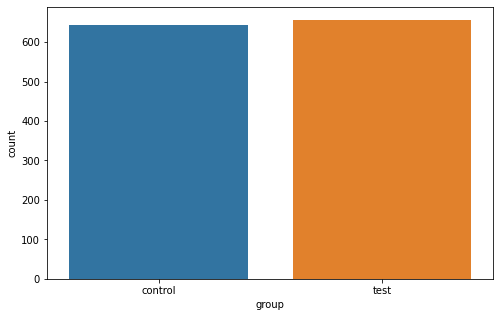

In [13]:
sns.countplot(data=df, x='group');

In [14]:
df.group.value_counts()

test       656
control    644
Name: group, dtype: int64

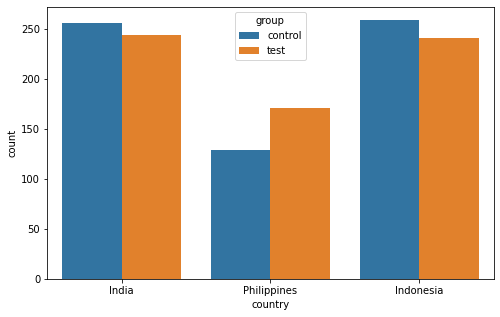

In [15]:
sns.countplot(data=df, x='country', hue='group');

Видим, что выборки по размеру равные, ~650 наблюдений в каждой.  
По странам наблюдается небольшой дисбаланс, тестовая выборка доминирует в Филиппинах и слегка отстаёт в Индии и Индонезии по кол-ву записей.  
Надеюсь, A/A тест был проведён и стат.значимых различий в выборках предыдущий исследователь не заметил :)

Посмотрим на среднее значение чека и конверсии в КОНТРОЛЬНОЙ выборке.  
Также интересно узнать, насколько это значение зависит от страны.

In [16]:
control = df[df.group == 'control']

In [17]:
conv_control = control[['country', 'conversion']].groupby(by='country').sum()
conv_control = conv_control.reset_index()

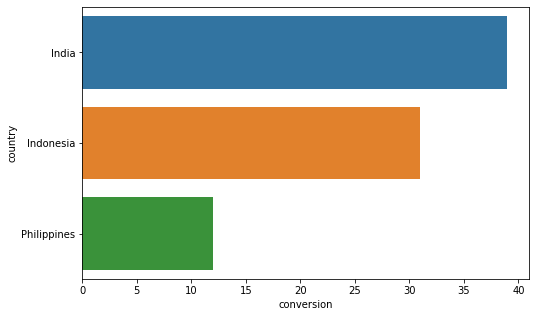

In [18]:
sns.barplot(data=conv_control, x='conversion', y='country');

In [19]:
conv_control

,country,conversion
0,India,39.0
1,Indonesia,31.0
2,Philippines,12.0


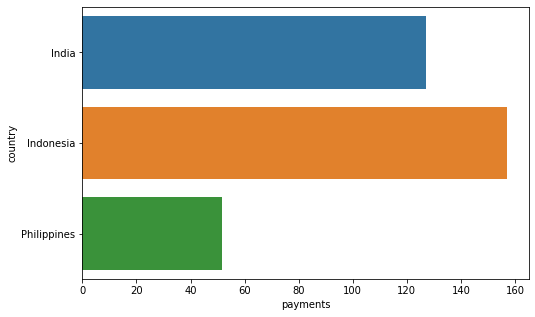

In [20]:
pay_control = control[['country', 'payments']].groupby(by='country').sum()
pay_control = pay_control.reset_index()
sns.barplot(data=pay_control, x='payments', y='country');

In [21]:
pay_control

,country,payments
0,India,127.16
1,Indonesia,157.20
2,Philippines,51.81


Возможно, это не самые показательные графики, т.к. количество наблюдений в странах разное.  
Лучше мы нарисуем конверсию/количество_клиентов, т.е. процент конверсии для каждой страны. И также средний доход с человека для каждой страны.

In [22]:
client_per_country = control.groupby(by='country').count()['conversion'].values

In [23]:
conv_control['conversion_percent'] = conv_control['conversion'] / client_per_country
conv_control

,country,conversion,conversion_percent
0,India,39.0,0.152344
1,Indonesia,31.0,0.119691
2,Philippines,12.0,0.093023


In [24]:
pay_control['avg_payment'] = pay_control['payments'] / client_per_country
pay_control

,country,payments,avg_payment
0,India,127.16,0.496719
1,Indonesia,157.20,0.606950
2,Philippines,51.81,0.401628


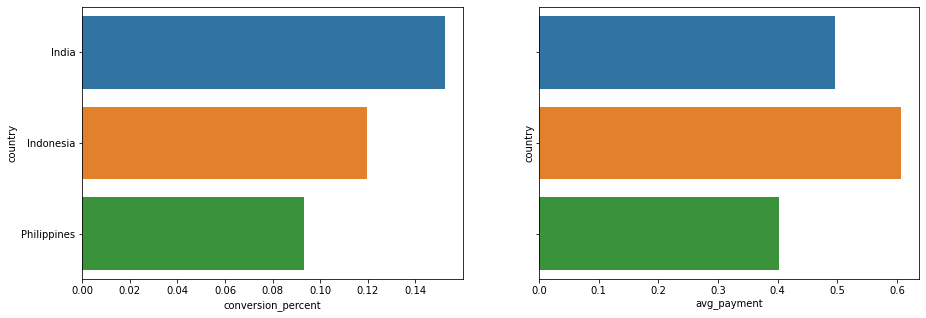

In [25]:
plt.rcParams["figure.figsize"] = (15,5)
fig, axes = plt.subplots(1, 2, sharey=True)
# fig = plt.figure(figsize=(8, 10))
sns.barplot(data=conv_control, x='conversion_percent', y='country', ax=axes[0])
sns.barplot(data=pay_control, x='avg_payment', y='country', ax=axes[1])
plt.show();

На этих графиках наглядно видно, что средний клиент каждой страны отличается.  
В Индии часто заходят посмотреть на услугу, увеличивая нам конверсию. 
Клиенты из Индонезии более платёжеспособные и приносят нам больше денег в среднем.  
Филиппинцы отстают во всём от двух других стран.  

Напомню, что в тестовой группе филиппинцев больше, чем в контрольной, клиентов же из Индии и Индонезии в тесте меньше. Вообще говоря, это может исказить наше предположение, что группы теста и контроля гомогенны.

Но мы доверимся тем, кто собирал данные и создавал выборку и будем считать, что группы по природе своей однородны и что на изменения в показателях влияет только случайность и наше воздействие на тестовую группу.

Изучим также исторические средние значения(средние значения контрольной группы) для конверсии и чека, которые поздней будем использовать для формулирования гипотез.

In [26]:
control.describe()

,conversion,payments
count,644.000000,644.000000
mean,0.127329,0.522003
std,0.333600,1.916929
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,22.770000


Нас также интересует нормальность распределения данных и гомогенность дисперсий в группах. Это важно для проведения t-testа, например.

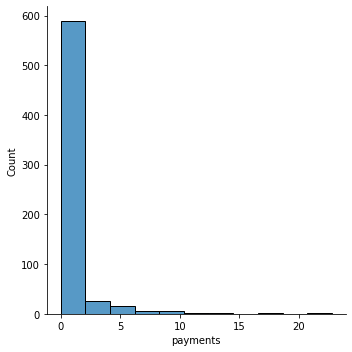

In [27]:
sns.displot(data=control, x='payments');

In [28]:
from scipy.stats import levene

_, conv_p_value = levene(control['conversion'],  df[df.group == 'test']['conversion'], center='median')
_, pay_p_value = levene(control['payments'],  df[df.group == 'test']['payments'], center='median')
conv_p_value, pay_p_value

(0.0008856044551950971, 0.0003674848649422895)

Из графика и теста Левене видно, что данные распределены не нормально и дисперсии не гомогенны(маленькое p-value у Левене говорит нам о непринятии нулевой гипотезы о равности дисперсий).
t-test тут использовать нельзя.

---
### Гипотезы и параметры теста

In [29]:
control.conversion.sum(), control.payments.sum()

(82.0, 336.17)

Мы немного посмотрели на данные. Что мы знаем:
*   Рамер выборки ~650 
*   Исторический mean и std для конверсии: 0.127 и 0.337
*   Исторический mean и std для чека: 0.522 и 1.917
*   Порог p-value = 0.05, мощность теста = 0.8



И тут я заметил, что в задании не сказано о том, какой MDE(минимальный эффект) мы бы хотели задетектировать для того, чтобы считать тест успешным. Поэтому будем просто рассматривать случай, когда выборки отличаются больше, чем на 0.

#### Определим гипотезы. (HA - hypothesis alternative)
>1. H0-1 гипотеза: "Группы не отличаются по уровню конверсии."  
2. H0-2 гипотеза: "Группы не отличаются по уровню среднего чека."

Будем проводить двусторонний A/B тест. 
> 1. HA-1 гипотеза: "В тестовой группе конверсия отличается от конверсии в контрольной группе больше, чем на 0."  
2. HA-2 гипотеза: "В тестовой группе средний чек отличается от чека в контрольной группе больше, чем на 0."

---

>
Наконец мы можем немножко посмотреть на тестовую группу!

### Визуализация разницы теста и контроля

In [30]:
plt.rcParams["figure.figsize"] = (8,5)

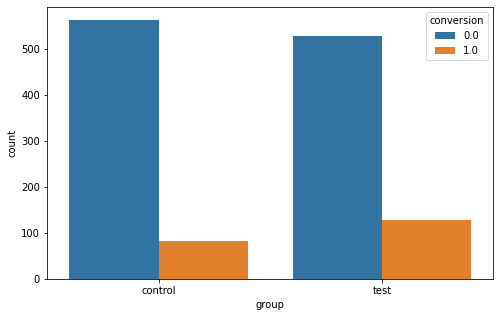

In [31]:
sns.countplot(data=df, x='group', hue='conversion');

In [32]:
pd.crosstab(df['group'], df['conversion'], normalize=True)

conversion,0.0,1.0
group,,
control,0.432308,0.063077
test,0.406154,0.098462


In [33]:
df[['group', 'payments']].groupby(by='group').sum()

,payments
group,
control,336.17
test,719.57


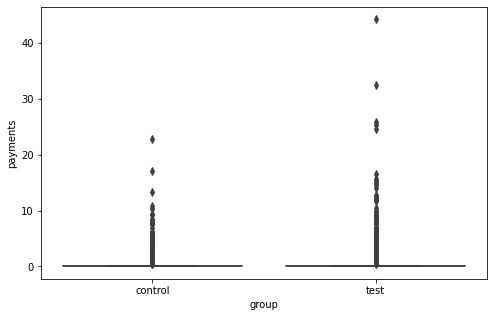

In [34]:
sns.boxplot(data=df, y='payments', x='group');

Нулевые значения слишком сильно "скашивают" распределение, давайте посмотрим график только для тех, где покупка была совершена.

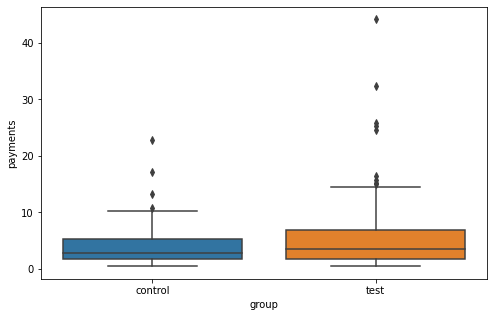

In [35]:
sns.boxplot(data=df[df['conversion'] == 1], y='payments', x='group', order=['control', 'test']);

По графикам и таблицам можно увидеть некоторую разницу.  
Процент конверсии увеличился, это видно. 

Средний чек по медиане всё ещё выглядит сравнительно похожим для теста и контроля, но хвост дорогих покупок(точек-выбросов на графике) увеличился для теста почти в два раза.

---

## Bootstrap

Давайте посмотрим, насколько значимы различия. Т.к. дисперсии не гомогенны и данные не распределены нормально, мы не будем использовать t-test. 

Используем бутстрап и посмотрим на разницы средних значений. Если их доверительные интервалы не пересекаются с нулём, то разница в группах будет статистически значимой.

Используем вот такой бутстрап для двусторонней проверки гипотезы, оценивающий разницу двух групп с визуализацией доверительных интервалов.

In [36]:
from tqdm import tqdm
from scipy.stats import norm

def get_bootstrap(
    data_column_1, # first group samples
    data_column_2, # second group samples
    boot_it = 1000, # amount of bootstrap iterations
    statistic = np.mean, # statistic we are looking for
    bootstrap_conf_level = 0.95 # confidence level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extraction of subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # with returns because it's bootstrap
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    # plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Разница в проценте конверсии

100%|██████████| 1000/1000 [00:00<00:00, 3693.86it/s]


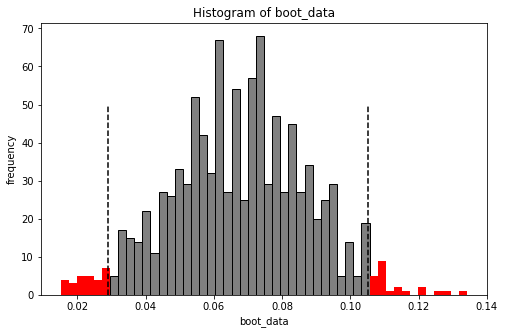

P_VALUE =  0.0006334047823479689


In [37]:
booted_data = get_bootstrap(
    df[df['group'] == 'test']['conversion'],
    df[df['group'] == 'control']['conversion'],
)
print('P_VALUE = ', booted_data['p_value'])

#### Разница с среднем чеке

100%|██████████| 1000/1000 [00:00<00:00, 3523.18it/s]


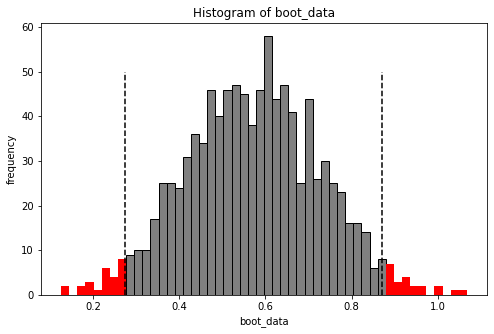

P_VALUE =  0.00019326013601199987


In [38]:
booted_data = get_bootstrap(
    df[df['group'] == 'test']['payments'],
    df[df['group'] == 'control']['payments'],
)
print('P_VALUE = ', booted_data['p_value'])

## Выводы
Очевидно, что по обеим метрикам мы получили статистически значимые различия!  
Даже если мы применим самую консервативную поправку Бонферрони, оба полученных p-value находятся ниже, чем 0.025 = 0.05/2 (Бонферрони для двух тестов).

Отлично, таким образом мы принимаем обе альтернативные гипотезы.  
Наше улучшение для тестовой группы показало себя отлично. Можно выкатывать его на прод, ура!

*Последнее замечание*: метрики конверсии и среднего чека связаны друг с другом. Об этом стоит помнить, т.к увеличение конверсии само по себе увеличивает средний чек на одного пользователя даже в случае, если распределение средних чеков остаётся тем же. 
Я не уверен, надо ли оценивать и показывать эту связь. Возможно, тут стоит советоваться с бизнесом.